In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
import pandas as pd
import itertools
from collections import namedtuple
from plotnine import *
from multiprocessing import Pool
from IPython.core import display as ICD
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, classification_report, log_loss, accuracy_score
from sklearn import datasets
from sklearn.externals import joblib


## Importing and Reformatting Data

We need to import the data we made in the other notebook and reformat it a bit to make it easier to work with in this notebook.

In [3]:
pd.set_option('display.max_columns', None)

animals_binary = pd.read_csv('binary_imputed_train.csv')
#animals_binary.drop(['AnimalID', 'OutcomeSubtype'], axis=1, inplace=True)
ICD.display(animals_binary.head())

animals = pd.read_csv('imputed_train.csv')
animals = animals.iloc[:, [2] + range(7, len(animals.columns))]
animals.drop(['AnimalID', 'OutcomeSubtype'], axis=1, inplace=True)
ot = animals.pop('OutcomeType')
animals.insert(0, 'OutcomeType', ot)
ICD.display(animals.head())

,HasName_0,Year_0,Year_1,Month_0,Month_1,Month_2,Month_3,Weekday_0,Weekday_1,Weekday_2,Hour_0,Hour_1,Hour_2,Hour_3,Hour_4,WeekofYear_0,WeekofYear_1,WeekofYear_2,WeekofYear_3,WeekofYear_4,WeekofYear_5,DayofMonth_0,DayofMonth_1,DayofMonth_2,DayofMonth_3,DayofMonth_4,isHoliday_0,AgeinDays_0,AgeinDays_1,AgeinDays_2,AgeinDays_3,AgeinDays_4,AgeinDays_5,LifeStage_0,LifeStage_1,LifeStage_2,BernoulliSex_0,BernoulliSex_1,AvgWeight(pounds)_0,AvgWeight(pounds)_1,AvgWeight(pounds)_2,AvgWeight(pounds)_3,AvgWeight(pounds)_4,AvgWeight(pounds)_5,AvgWeight(pounds)_6,SizeScore(1to5)_0,SizeScore(1to5)_1,SizeScore(1to5)_2,Intelligent_0,Intelligent_1,Intelligent_2,Friendliness_0,Friendliness_1,AvgAge_0,AvgAge_1,AvgAge_2,AvgAge_3,MixType_0,MixType_1,Hair_0,Hair_1,BlendedColor_0,BlendedColor_1,BlendedColor_2,BlendedColor_3,BlendedColor_4,ReducedPattern_0,ReducedPattern_1,ReducedPattern_2,OutcomeType
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Return_to_owner
1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,Euthanasia
2,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,Adoption
3,1,0,0,0,0,1,1,0,1,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,Transfer
4,1,0,1,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,1,0,Transfer


,OutcomeType,AnimalType,HasName,Year,Month,Weekday,Hour,WeekofYear,DayofMonth,isHoliday,AgeinDays,LifeStage,BernoulliSex,AvgWeight(pounds),SizeScore(1to5),Intelligent,Friendliness,AvgAge,MixType,Hair,BlendedColor,ReducedPattern
0,Return_to_owner,Dog,1.0,2014,2,2,18,7,12,False,365.0,Puppy/Kitten,Neutered Male,28.0,2.0,5.0,4.0,13.0,Mix,Short,rosybrown,BiColor
1,Euthanasia,Cat,1.0,2013,10,6,12,41,13,True,365.0,Puppy/Kitten,Spayed Female,9.0,1.0,3.0,3.0,12.0,Mix,Short,tan,Tabby
2,Adoption,Dog,1.0,2015,1,5,12,5,31,True,730.0,Young Adult,Neutered Male,60.0,4.0,3.0,2.0,12.0,Mix,Short,silver,BiColor
3,Transfer,Cat,0.0,2014,7,4,19,28,11,True,21.0,Infant,Intact Male,9.0,1.0,3.0,3.0,16.0,Mix,Short,rosybrown,Solid
4,Transfer,Dog,0.0,2013,11,4,12,46,15,False,730.0,Young Adult,Neutered Male,14.0,2.0,4.0,4.0,15.0,Cross,Short,tan,Solid


Here we want a list of the continuous and discrete fields to try one-hot encoding or ordinal encoding. Also we want to be able to comment out certain features that after trial and error don't seem to help. The fields we ended up using are shown below uncommented. 

In [4]:
animals.rename(columns={'AvgWeight(pounds)': 'AvgWeight', 'SizeScore(1to5)': 'SizeScore'}, inplace=True)

continuous=[
    'AgeinDays', 
    'AvgWeight', 
    'AvgAge'
]

# Ensure order is correct if treated as continuous (value of dictonary). Doing 1-hot doesn't seem to work as
# well with RF. But order matters a lot here (i.e. LifeStage won't work properly if not set as below -- the 
# order it automatically creates is not in the order of the stages). Commenting out the features that don't 
# work after trail and error (on RF).
discrete = dict(
    AnimalType = None,
    HasName = None,
    Year = None,
    Month = range(12),
    Weekday = range(7),
    Hour = [0] + range(5, 24),
    WeekofYear = range(53),
    DayofMonth = range(31), # why does this one matter, seems it shouldn't -- need to try without
#    isHoliday = None,
#    LifeStage = ["Unknown", "Infant", "Puppy/Kitten", "Young Adult", "Adult", "Senior", "Geriatric"],
    BernoulliSex = ['Intact Male', 'Intact Female', 'Neutered Male', 'Spayed Female'],
#    SizeScore = range(1, 6),
#    Intelligent = range(2, 6),
#    Friendliness = range(1, 6),
    MixType = ['Cross', 'Mix', 'Pure'],
#    Hair = ['Long', 'Medium', 'Short'],
#    BlendedColor = None,
#    ReducedPattern = ['Solid', 'BiColor', 'TriColor', 'Tabby', 'Mertle', 'Point', 'Smoke']
)

This simply produces the final data frame to learn form.

In [5]:
encode_discrete_as_one_hot = False

df = pd.DataFrame(animals.iloc[:, 0].copy())
for c in animals.columns[1:]:
    if c in continuous:        
        df[c] = animals[c]
    elif c in discrete.keys():        
        if encode_discrete_as_one_hot:
            df = pd.concat([df, pd.get_dummies(pd.Categorical(animals[c]), prefix=c)], axis=1)            
        else:
            df[c] = pd.Categorical(animals[c], categories=discrete[c]).codes
            
df.head()
    

,OutcomeType,AnimalType,HasName,Year,Month,Weekday,Hour,WeekofYear,DayofMonth,AgeinDays,BernoulliSex,AvgWeight,AvgAge,MixType
0,Return_to_owner,1,1,1,2,2,14,7,12,365.0,2,28.0,13.0,1
1,Euthanasia,0,1,0,10,6,8,41,13,365.0,3,9.0,12.0,1
2,Adoption,1,1,2,1,5,8,5,-1,730.0,2,60.0,12.0,1
3,Transfer,0,0,1,7,4,15,28,11,21.0,0,9.0,16.0,1
4,Transfer,1,0,0,11,4,8,46,15,730.0,2,14.0,15.0,0


These are all the functions that we need.

In [11]:
def skf_generator(data, n_splits):
    skf = StratifiedKFold(n_splits, random_state=8, shuffle=True)
    t = data.OutcomeType
    for train_index, test_index in skf.split(np.zeros(len(t)), t):
        yield train_index, test_index
        
        
def run_skf(data, n_splits):
    splits = [(data.iloc[train_index], data.iloc[test_index]) 
              for train_index, test_index in skf_generator(data, n_splits=n_splits)]
    return zip(*splits) # return seperate lists of train/test instead of one combined


def visualize_folds(data, train, test):
    print('Number of training samples: {}\n'.format(len(data)))
    print('Training sample size per fold:')
    summary = pd.DataFrame([
        f.groupby('OutcomeType')
        .count()
        .iloc[:, 0]
        .rename('Fold {}'.format(i+1)) 
        for i, f in enumerate(train)])
    summary['Any'] = summary.sum(axis=1)
    summary.columns = summary.columns.rename('')
    ICD.display(summary)

    print('Test samples per fold:')
    summary = pd.DataFrame([
        f.groupby('OutcomeType')
        .count()
        .iloc[:, 0]
        .rename('Fold {}'.format(i+1)) 
        for i, f in enumerate(test)])
    summary['Any'] = summary.sum(axis=1)
    summary.columns = summary.columns.rename('')
    ICD.display(summary)

    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=90)
    
    
def plot_results(X, t, target_names, loss, pred, n_splits, show_title=True):
    print('')
    if show_title:
        print('Fold {} of {}'.format(len(loss.train), n_splits))
        print('Train log loss: {}'.format(loss.train[-1]))
    print('Test log loss: {}'.format(loss.test[-1]))
    
    if show_title:
        title = 'Confusion Matrix for Fold {0} of {1}'.format(len(loss.train), n_splits)
    else:
        title = ""
    cm = confusion_matrix(t.test, pred.test, labels=target_names)
    plot_confusion_matrix(
        cm, target_names,
        title=title)
    print(classification_report(t.test, pred.test, target_names=target_names))
    
    
def plot_importance(clf, X, t):
    print('Classifier score (accuracy): {}'.format(clf.score(X.test, t.test)))

    if not hasattr(clf, 'feature_importances_'):
        return
    # Print the feature ranking
    importances = clf.feature_importances_
    if not hasattr(clf.estimators_[0], 'feature_importances_'):
        return
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.train.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.train.shape[1]), X.train.columns[indices], rotation=90)
    plt.xlim([-1, X.train.shape[1]])
    plt.show()
    
    
def create_output(t_true, t_pred, target_names):
    k1 = pd.get_dummies(t_pred, columns=target_names)
    k1 = k1.reindex_axis(target_names, axis=1)
    k1.fillna(0, inplace=True)
    return k1


def calc_ln_loss(t_true, t_pred, target_names):
    return log_loss(t_true, t_pred)


def ln_loss_scorer(clf, X, t):
    """
    Used for grid searching and ensemble methods that accept a scoring function.
    Need to return the negative log loss for grid search to pick the best one as 
    it tries to maximize the value here (so negative log likelihood).
    """
    pred = clf.predict_proba(X)
    return log_loss(t, pred) * -1


TrainTest = namedtuple('TrainTest', 'train, test')


def run_classifier(clf, X, t, target_names, loss):    
    clf.fit(X.train, t.train)
    pred = TrainTest(pd.Categorical(clf.predict(X.train), categories=target_names),
                     pd.Categorical(clf.predict(X.test), categories=target_names))

    pred_proba = TrainTest(clf.predict_proba(X.train), clf.predict_proba(X.test))
    
    loss.train.append(calc_ln_loss(t.train, pred_proba.train, target_names))
    loss.test.append(calc_ln_loss(t.test, pred_proba.test, target_names))
    
    return clf, pred, loss


def run_classifier_CV(clf, train, test, target_names, loss, plot=False):
    clfs = []
    for i in range(len(train)):
        this_clf = clone(clf)
        # Outcome is in the first column [index 0]
        X = TrainTest(train[i].iloc[:, 1:], test[i].iloc[:, 1:])
        t = TrainTest(pd.Categorical(train[i].OutcomeType, categories=target_names),
                      pd.Categorical(test[i].OutcomeType, categories=target_names))
        this_clf, pred, loss = run_classifier(this_clf, X, t, target_names, loss)
        if plot:
            plot_results(X, t, target_names, loss, pred, len(train))
            plot_importance(this_clf, X, t)
        clfs.append(this_clf)
    return clfs


def plot_hypervariable(result, variable):
    columns = ['count', 'train', 'test']
    loss = pd.DataFrame(result, columns=columns)
    loss = pd.melt(loss, id_vars=['count'], value_vars=columns[1:])

    (ggplot(loss, aes(x='count', y='value', color='variable'))
     + geom_line(size=1)
     + theme_seaborn()
     + theme(panel_grid_minor = element_line(size=0.5))
     + ylab('Log Loss')
     + xlab(variable)
    ).draw().set_size_inches(4, 4)
    
    
def print_grid_cv_results(clf, X, t):
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    score = []
    param = []
    for i, (mean, std, params) in enumerate(zip(means, stds, clf.cv_results_['params'])):
        score.append([i, "%0.3f" % mean,"+/- %0.03f" % (std * 1.96)])
        params['canidate'] = i
        param.append(pd.DataFrame(params, index=[0], columns=params.keys()))
        
    canidates = pd.merge(pd.DataFrame(score, columns=['canidate', 'score', '95% CI']), 
                         pd.concat(param), left_on='canidate', right_on='canidate')
    canidates.drop('canidate', inplace=True, axis=1)
    canidates.sort_values(['score' , '95% CI'], ascending=[1, 1], inplace=True)
    ICD.display(canidates)

## Train, Test, and Hold Out Sets

Let's split the data into first a training set and a hold out set -- the latter for for making predictions of how we'll perform on Kaggle. Of the training data we split this into 8 stratified folds.

In [12]:
n_splits = 8
target_names = sort(df.OutcomeType.unique())
data, hold_out = train_test_split(df, test_size=1./(n_splits+1), random_state=8)
print 'Number of samples before splitting: {}'.format(len(df))
print 'Number of hold out samples: {}'.format(len(hold_out))
train, test = run_skf(data, n_splits)
visualize_folds(data, train, test)

Number of samples before splitting: 26729
Number of hold out samples: 2970
Number of training samples: 23759

Training sample size per fold:


,Adoption,Died,Euthanasia,Return_to_owner,Transfer,Any
Fold 1,8384,151,1223,3709,7321,20788
Fold 2,8384,151,1223,3709,7321,20788
Fold 3,8384,151,1223,3709,7321,20788
Fold 4,8384,151,1223,3709,7321,20788
Fold 5,8384,151,1223,3709,7321,20788
Fold 6,8384,152,1223,3709,7321,20789
Fold 7,8385,152,1224,3709,7321,20791
Fold 8,8385,152,1224,3710,7322,20793


Test samples per fold:


,Adoption,Died,Euthanasia,Return_to_owner,Transfer,Any
Fold 1,1198,22,175,530,1046,2971
Fold 2,1198,22,175,530,1046,2971
Fold 3,1198,22,175,530,1046,2971
Fold 4,1198,22,175,530,1046,2971
Fold 5,1198,22,175,530,1046,2971
Fold 6,1198,21,175,530,1046,2970
Fold 7,1197,21,174,530,1046,2968
Fold 8,1197,21,174,529,1045,2966


## Random Forest

Let's get an idea of how random forest does on this dataset as we increase the number of trees. We expect that it should keep improving as the number of trees increases. The only downside is it takes more time to run.

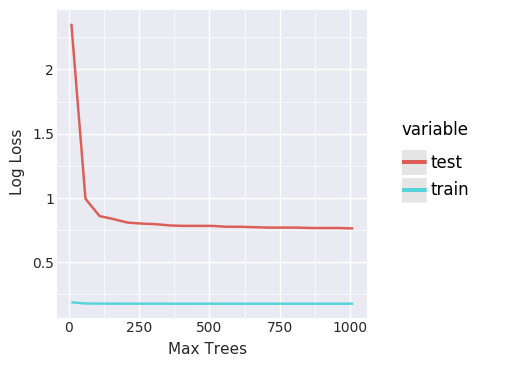

In [13]:
# Takes a while. Only run if needed, and use as many processes as needed as there is no progress display.

def iteration(i):
    try:
        clf = RandomForestClassifier(n_estimators=i, max_depth=None, 
                                     random_state=8, max_features='auto')
        loss = TrainTest([], [])        
        run_classifier_CV(clf, train[:3], test[:3], target_names, loss)
        return (i, sum(loss.train) / 3, sum(loss.test) / 3)
    except:
        import traceback
        traceback.print_exc()

range_ = range(10, 1050, 50)
p = Pool(processes=40)
result = p.map(iteration, range_)
p.close()
p.join()

plot_hypervariable(result, 'Max Trees')

Now let's get an approximate value for the best depth of the tree. For speed we'll set it at 100 trees and leave everything else as default.

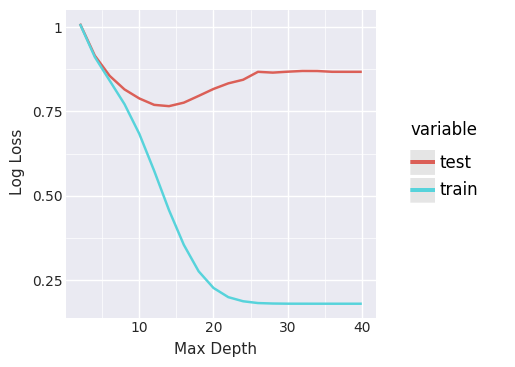

In [16]:
# Takes a while. Only run if needed, and use as many processes as needed as there is no progress display.

def iteration(i):
    try:
        clf = RandomForestClassifier(n_estimators=100, max_depth=i, 
                                     random_state=8, max_features='auto')
        loss = TrainTest([], [])
        run_classifier_CV(clf, train, test, target_names, loss)
        return (i, sum(loss.train) / n_splits, sum(loss.test) / n_splits)
    except:
        import traceback
        traceback.print_exc()

range_ = range(2, 42, 2)
p = Pool(processes=40)
result = p.map(iteration, range_)
p.close()
p.join()

plot_hypervariable(result, 'Max Depth')

### RF Grid Search

Now, with the above information, let's try to tune for other hyperparameters like bootstraping, criterion, max_features, and the minimum number of samples per split. It turns out some of these don't seem to change as we search this hyperparameter space using grid search. The results of the grid search are sorted by score.

In [80]:
X = data.iloc[:, 1:]
t = data.OutcomeType

param = [{'n_estimators': [250],             # 100 < 250 -- In all cases seen
          'max_depth': [14, 15, 16],
#           'criterion': ['gini', 'entropy'],# entropy < gini -- ditto
          'max_features': ['sqrt', 2, 4, 5],
          'bootstrap': [False],              # True < False -- ditto
          'min_samples_split': [2, 3, 4]}]

rf_clf = RandomForestClassifier(random_state=8)

clf = GridSearchCV(rf_clf, param, scoring=ln_loss_scorer, n_jobs=-1,
                   cv=skf_generator(data, n_splits), verbose=1)

clf.fit(X, t)

print X.columns

print_grid_cv_results(clf, X, t)

Fitting 8 folds for each of 36 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  2.4min finished


Index([u'AnimalType', u'HasName', u'Year', u'Month', u'Weekday', u'Hour',
       u'WeekofYear', u'DayofMonth', u'AgeinDays', u'BernoulliSex',
       u'AvgWeight', u'AvgAge', u'MixType'],
      dtype='object')


,score,95% CI,bootstrap,n_estimators,min_samples_split,max_features,max_depth
6,-0.741,+/- 0.030,False,250,2,4,14
26,-0.741,+/- 0.031,False,250,4,sqrt,16
19,-0.741,+/- 0.036,False,250,3,4,15
12,-0.742,+/- 0.027,False,250,2,sqrt,15
8,-0.743,+/- 0.029,False,250,4,4,14
7,-0.743,+/- 0.031,False,250,3,4,14
14,-0.743,+/- 0.032,False,250,4,sqrt,15
25,-0.743,+/- 0.032,False,250,3,sqrt,16
1,-0.744,+/- 0.023,False,250,3,sqrt,14
0,-0.744,+/- 0.029,False,250,2,sqrt,14


Ideally, for random forest we shouldn't too high of correlation between our features, otherwise when considers randomly one over the other at a split we might increase our variance quite a bit. Correlations seem to be fairly low despite most being positive. Some are negative as well.

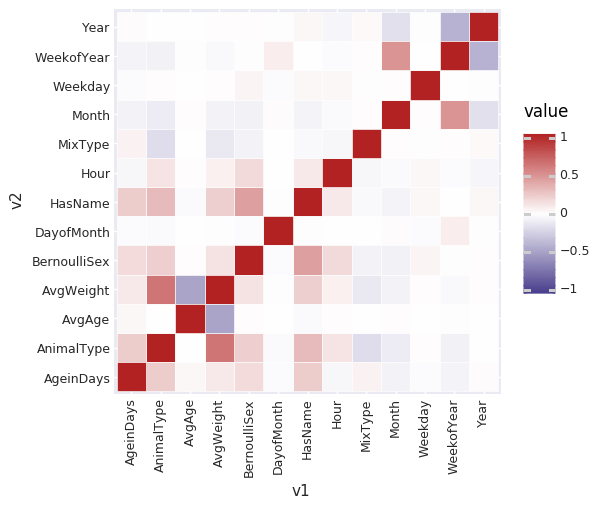

In [81]:
df_corr = df.corr()
df_corr = df_corr.stack().reset_index()
df_corr.columns = ['v1','v2','value']

(ggplot(df_corr, aes(x='v1', y='v2', fill='value'))
 + geom_tile(color='white', size=0.25)
 + scale_fill_gradientn(colors=('darkslateblue', 'white', 'firebrick'), limits=(-1,1))
 + theme_seaborn()
 + theme(axis_text_x = element_text(angle = 90, size=9),
         axis_text_y = element_text(size=9))
 + coord_equal()
).draw().set_size_inches(5,5)

Using the information above from the hyperparameter tuning, let's increase the number of trees to 1000 and print out more detailed information about the performance of this classifer. Also I'd expect that we'd liekly see an improvement to the mean score and variance with a higher number of trees. So it should be worth the extra training time. We also measured feature importance, but bear mind when looking at this kind of data it will tend favor features that have more classes. We also plot the confusion matrix to see where the classifier struggles to perform well (such as having a harder time distingishing Return to owner and Tranfer from Adoption. Later we'll talk about how we can use the confusion matrix to compare two different classifers.

### Running Tuned Hyper-parameters


Fold 1 of 8
Train log loss: 0.39367389946
Test log loss: 0.74007238151
                 precision    recall  f1-score   support

       Adoption       0.71      0.83      0.76      1198
           Died       0.67      0.09      0.16        22
     Euthanasia       0.65      0.21      0.31       175
Return_to_owner       0.50      0.51      0.50       530
       Transfer       0.79      0.73      0.76      1046

    avg / total       0.70      0.69      0.68      2971

Classifier score (accuracy): 0.694715583978


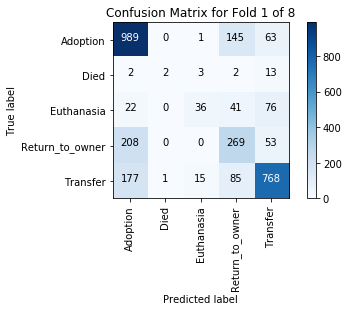

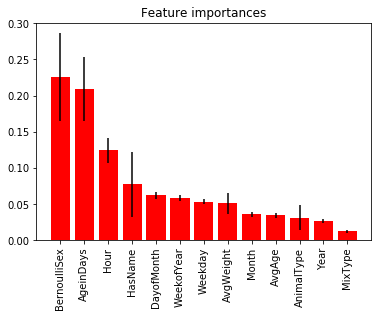


Fold 2 of 8
Train log loss: 0.395989461597
Test log loss: 0.744207926997
                 precision    recall  f1-score   support

       Adoption       0.71      0.83      0.76      1198
           Died       1.00      0.05      0.09        22
     Euthanasia       0.62      0.25      0.36       175
Return_to_owner       0.52      0.54      0.53       530
       Transfer       0.78      0.71      0.74      1046

    avg / total       0.70      0.70      0.69      2971

Classifier score (accuracy): 0.695052170986


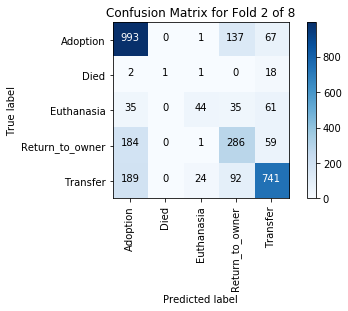

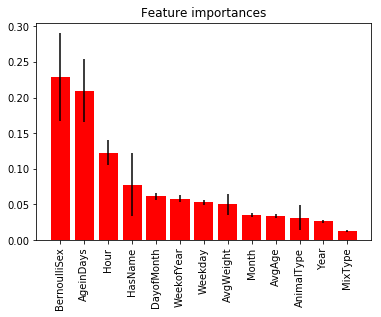


Fold 3 of 8
Train log loss: 0.393353847855
Test log loss: 0.734072577468
                 precision    recall  f1-score   support

       Adoption       0.72      0.86      0.79      1198
           Died       0.00      0.00      0.00        22
     Euthanasia       0.52      0.17      0.26       175
Return_to_owner       0.54      0.48      0.51       530
       Transfer       0.77      0.75      0.76      1046

    avg / total       0.69      0.71      0.69      2971

Classifier score (accuracy): 0.706832716257


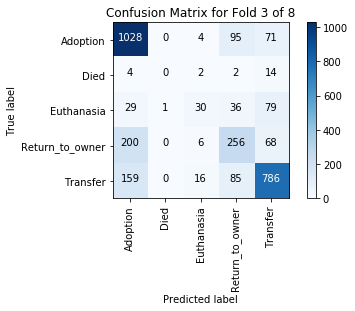

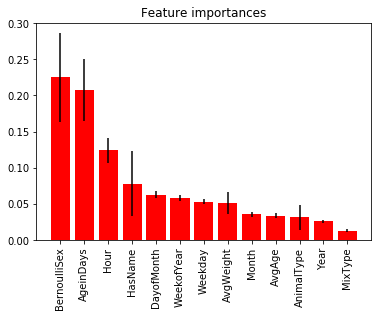


Fold 4 of 8
Train log loss: 0.389390594642
Test log loss: 0.766094850932
                 precision    recall  f1-score   support

       Adoption       0.71      0.81      0.76      1198
           Died       0.50      0.09      0.15        22
     Euthanasia       0.60      0.20      0.30       175
Return_to_owner       0.50      0.53      0.51       530
       Transfer       0.78      0.73      0.75      1046

    avg / total       0.69      0.69      0.68      2971

Classifier score (accuracy): 0.69000336587


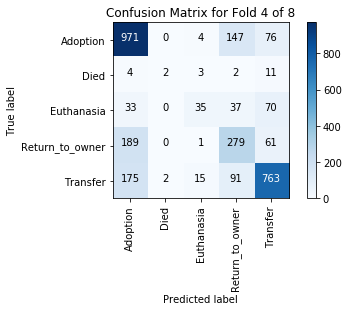

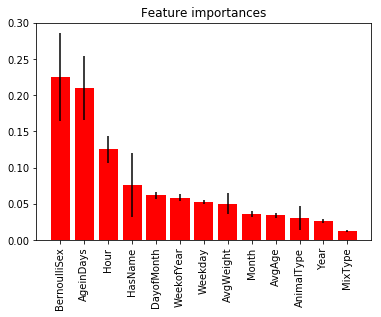


Fold 5 of 8
Train log loss: 0.396354978848
Test log loss: 0.745774871857
                 precision    recall  f1-score   support

       Adoption       0.73      0.83      0.77      1198
           Died       1.00      0.14      0.24        22
     Euthanasia       0.80      0.27      0.41       175
Return_to_owner       0.51      0.54      0.52       530
       Transfer       0.77      0.73      0.75      1046

    avg / total       0.71      0.70      0.69      2971

Classifier score (accuracy): 0.702457085157


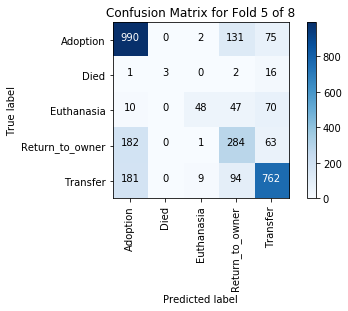

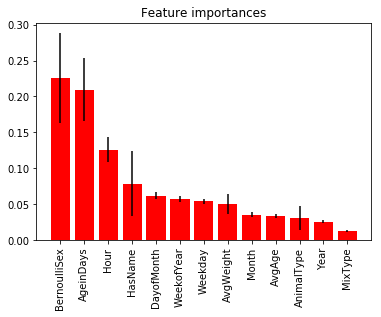


Fold 6 of 8
Train log loss: 0.397261364405
Test log loss: 0.722188357447
                 precision    recall  f1-score   support

       Adoption       0.73      0.84      0.78      1198
           Died       0.50      0.05      0.09        21
     Euthanasia       0.71      0.26      0.38       175
Return_to_owner       0.55      0.55      0.55       530
       Transfer       0.78      0.74      0.76      1046

    avg / total       0.71      0.71      0.70      2970

Classifier score (accuracy): 0.713468013468


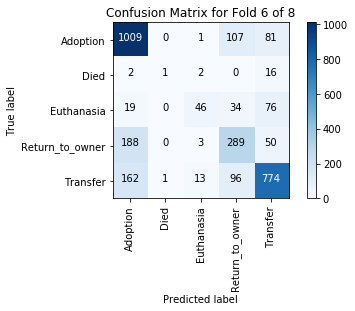

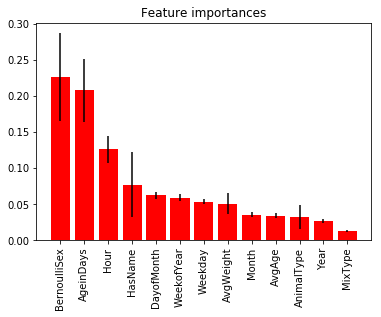


Fold 7 of 8
Train log loss: 0.394873703885
Test log loss: 0.720099670151
                 precision    recall  f1-score   support

       Adoption       0.72      0.84      0.77      1197
           Died       1.00      0.24      0.38        21
     Euthanasia       0.67      0.26      0.37       174
Return_to_owner       0.48      0.48      0.48       530
       Transfer       0.81      0.75      0.78      1046

    avg / total       0.71      0.71      0.70      2968

Classifier score (accuracy): 0.705188679245


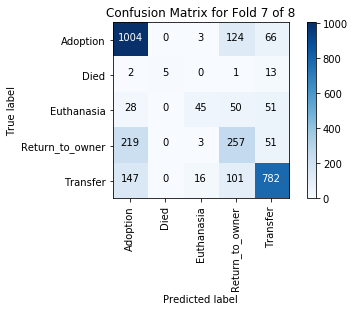

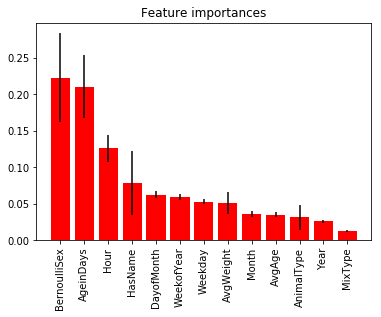


Fold 8 of 8
Train log loss: 0.395331709311
Test log loss: 0.738628185895
                 precision    recall  f1-score   support

       Adoption       0.73      0.82      0.77      1197
           Died       0.80      0.19      0.31        21
     Euthanasia       0.67      0.27      0.39       174
Return_to_owner       0.51      0.52      0.51       529
       Transfer       0.77      0.74      0.76      1045

    avg / total       0.70      0.70      0.69      2966

Classifier score (accuracy): 0.700944032367


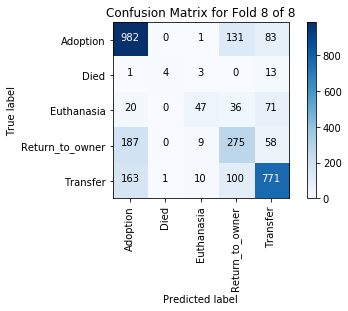

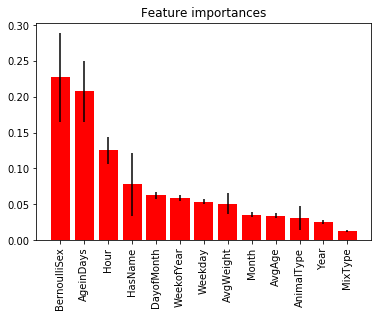

Avg. train log loss: 0.394528695 +/- 0.00450221820425
Avg. test log loss: 0.738892352782 +/- 0.0265910785409


In [11]:
rf_clf = RandomForestClassifier(n_estimators=1000, max_depth=14, bootstrap=False, 
                                min_samples_split=2, random_state=8, max_features=4, 
                                n_jobs=-1)

loss = TrainTest([], [])

clfs = run_classifier_CV(rf_clf, train, test, target_names, loss, plot=True)

print('Avg. train log loss: {} +/- {}'.format(np.mean(loss.train), np.std(loss.train) * 1.96))
print('Avg. test log loss: {} +/- {}'.format(np.mean(loss.test), np.std(loss.test)* 1.96))

### Does Soft Voting on Folds Help?

If we peak at the hold_out data we can use it to see if we get an improvement in the scores when soft voting via bagging on the k folds used for training compared to simply training with all available data. As this is the only purpose of this peak it should be okay. This will help us see if there is potential value in using bagging in this case or if it's just better to train with all our data. If the difference is small it might be better to avoid bagging if we decide to use an esemble method (like combining RF with other classifiers) for simplicity.

WITH Soft Voting on Folds:

Test log loss: 0.726671102813
                 precision    recall  f1-score   support

       Adoption       0.71      0.84      0.77      1187
           Died       1.00      0.08      0.15        24
     Euthanasia       0.66      0.27      0.38       157
Return_to_owner       0.51      0.50      0.50       547
       Transfer       0.80      0.74      0.77      1055

    avg / total       0.71      0.71      0.70      2970

WITHOUT Soft Voting on Folds:

Test log loss: 0.728914958156
                 precision    recall  f1-score   support

       Adoption       0.71      0.84      0.77      1187
           Died       1.00      0.08      0.15        24
     Euthanasia       0.65      0.26      0.37       157
Return_to_owner       0.50      0.50      0.50       547
       Transfer       0.80      0.74      0.77      1055

    avg / total       0.71      0.70      0.69      2970



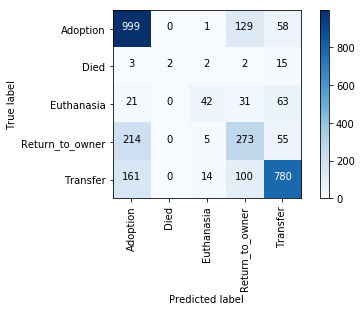

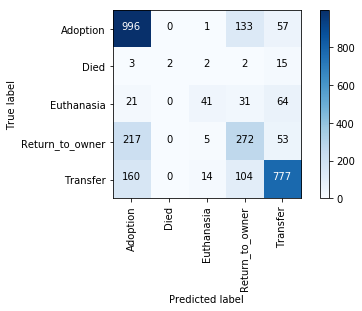

In [83]:
print("WITH Soft Voting on Folds:")

X = TrainTest(data.iloc[:, 1:], hold_out.iloc[:, 1:])
t = TrainTest(data.OutcomeType, hold_out.OutcomeType)
pred_proba = average([clfs[i].predict_proba(X.test) for i in range(n_splits)], axis=0)
pred = TrainTest(None, [target_names[argmax(pred_proba[i])] for i in range(len(X.test))])
loss = TrainTest(None, [calc_ln_loss(t.test, pred_proba, target_names)])
plot_results(X, t, target_names, loss, pred, 1, show_title=False)

print("WITHOUT Soft Voting on Folds:")
rf_clf.fit(X.train, t.train)
pred_proba = TrainTest(None, rf_clf.predict_proba(X.test))
pred = TrainTest(None, [target_names[argmax(pred_proba.test[i])] for i in range(len(X.test))])
loss = TrainTest(None, [calc_ln_loss(t.test, pred_proba.test, target_names)])
plot_results(X, t, target_names, loss, pred, 1, show_title=False)


## Gradient Boosting

Gradient Boosting took some time to tune as we when through multiple iterations of trying different parameter spaces to search. In the end the param options below are the ones that gave us the best result.

In [101]:
X = data.iloc[:, 1:]
t = data.OutcomeType

param = [{'n_estimators': [75, 100, 125],
          'learning_rate': [0.05, 0.025],
          'max_depth': [7, 8, 9],
          'subsample': [0.875, 0.8, 0.75]}]

gb_clf = GradientBoostingClassifier(random_state=8)

clf = GridSearchCV(gb_clf, param, scoring=ln_loss_scorer, n_jobs=-1,
                   cv=skf_generator(data, n_splits), verbose=1)

clf.fit(X, t)

print_grid_cv_results(clf, X, t)

Fitting 8 folds for each of 54 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 24.0min finished


,score,95% CI,n_estimators,subsample,learning_rate,max_depth
13,-0.741,+/- 0.029,100,0.800,0.050,8
14,-0.741,+/- 0.031,100,0.750,0.050,8
16,-0.742,+/- 0.030,125,0.800,0.050,8
17,-0.742,+/- 0.032,125,0.750,0.050,8
23,-0.743,+/- 0.029,100,0.750,0.050,9
7,-0.743,+/- 0.030,125,0.800,0.050,7
8,-0.743,+/- 0.030,125,0.750,0.050,7
12,-0.743,+/- 0.030,100,0.875,0.050,8
19,-0.744,+/- 0.028,75,0.800,0.050,9
15,-0.744,+/- 0.030,125,0.875,0.050,8


### Running GB with tuned Hyper-Parameters


Fold 1 of 8
Train log loss: 0.438123653174
Test log loss: 0.750980502422
                 precision    recall  f1-score   support

       Adoption       0.71      0.81      0.75      1198
           Died       0.50      0.14      0.21        22
     Euthanasia       0.67      0.27      0.38       175
Return_to_owner       0.50      0.51      0.50       530
       Transfer       0.78      0.73      0.76      1046

    avg / total       0.69      0.69      0.68      2971

Classifier score (accuracy): 0.691686300909

Fold 2 of 8
Train log loss: 0.441300214478
Test log loss: 0.748429745422
                 precision    recall  f1-score   support

       Adoption       0.71      0.81      0.75      1198
           Died       0.67      0.09      0.16        22
     Euthanasia       0.59      0.27      0.38       175
Return_to_owner       0.54      0.53      0.54       530
       Transfer       0.77      0.72      0.74      1046

    avg / total       0.69      0.69      0.69      2971

Clas

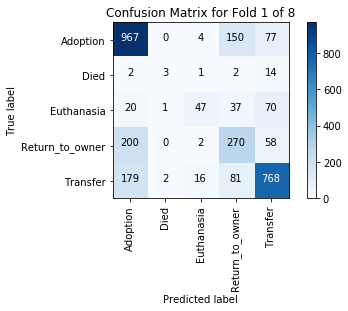

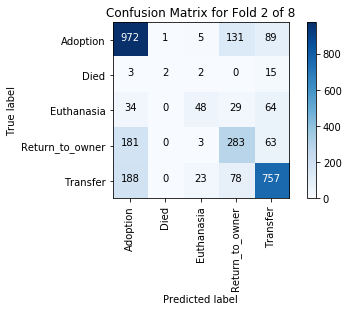

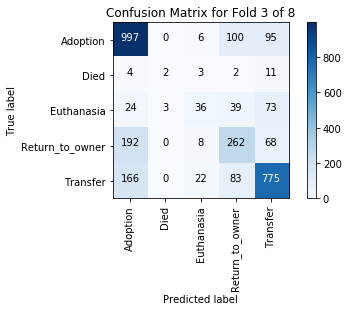

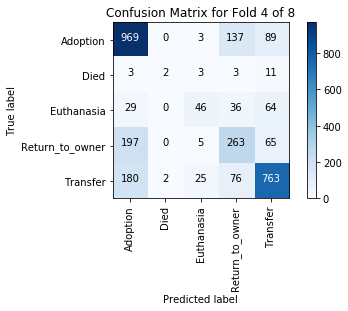

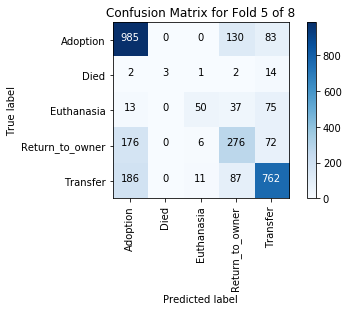

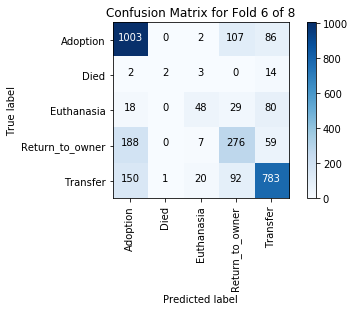

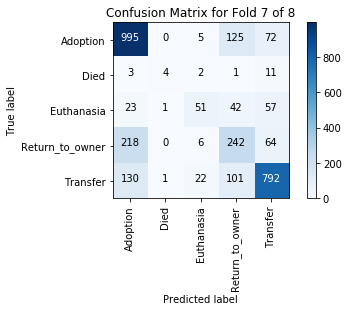

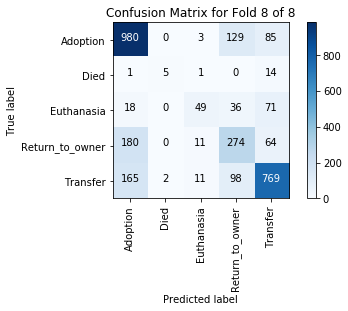

In [12]:
gb_clf = GradientBoostingClassifier(n_estimators=100, max_depth=8, 
                                    learning_rate=0.05, subsample=0.8, random_state=8)

loss = TrainTest([], [])
clfs = run_classifier_CV(gb_clf, train, test, target_names, loss, plot=True)

print('Avg. train log loss: {} +/- {}'.format(np.mean(loss.train), np.std(loss.train) * 1.96))
print('Avg. test log loss: {} +/- {}'.format(np.mean(loss.test), np.std(loss.test)* 1.96))

## Ensemble of RB and GB

GB and RF log loss are similar (although with the current tuning RF is better). However, looking at the confusion matrix GB does a bit better on Died and Euthanized, so an ensemble of the two will likely be helpful. Below we test this idea and also save the models to a file to make it easier to reuse.

In [15]:
X = data.iloc[:, 1:]
t = data.OutcomeType

voting_clf = VotingClassifier([('rf', rf_clf), ('gb', gb_clf)], voting='soft')

# score using cross validation
clf_list = [rf_clf, gb_clf, voting_clf]
name_list = ['Random Forest', 'Gradient Boosting', 'Ensemble']

for clf, name in zip(clf_list,name_list) :
    scores = cross_val_score(clf, X, t, scoring=ln_loss_scorer, cv=skf_generator(data, n_splits))
    print("Log Loss: %0.3f +/- %0.3f (%s 95%% CI)" % (scores.mean(), scores.std()*1.96, name))

Log Loss: -0.739 +/- 0.027 (Random Forest 95% CI)
Log Loss: -0.741 +/- 0.029 (Gradient Boosting 95% CI)
Log Loss: -0.729 +/- 0.026 (Ensemble 95% CI)


The result of the ensemble improved both the log loss and the variation between folds. Let's now get a prediction for how well we will do on Kaggle, using the hold out dataset.


Test log loss: 0.71908918418
                 precision    recall  f1-score   support

       Adoption       0.72      0.84      0.78      1187
           Died       1.00      0.08      0.15        24
     Euthanasia       0.67      0.26      0.38       157
Return_to_owner       0.52      0.50      0.51       547
       Transfer       0.80      0.75      0.77      1055

    avg / total       0.71      0.71      0.70      2970



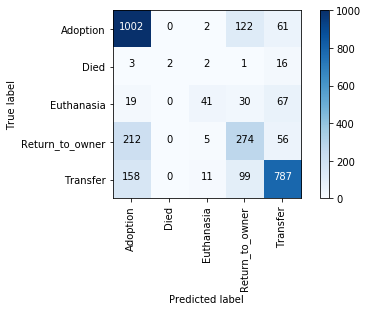

In [11]:
X = TrainTest(data.iloc[:, 1:], hold_out.iloc[:, 1:])
t = TrainTest(data.OutcomeType, hold_out.OutcomeType)

clf = joblib.load('voting_clf.pkl')

clf.fit(X.train, t.train)
pred_proba = TrainTest(None, clf.predict_proba(X.test))
pred = TrainTest(None, [target_names[argmax(pred_proba.test[i])] for i in range(len(X.test))])
loss = TrainTest(None, [calc_ln_loss(t.test, pred_proba.test, target_names)])
plot_results(X, t, target_names, loss, pred, 1, show_title=False)

## Predictions on the Kaggle Test Set

In [26]:
animals = pd.read_csv('what_matt_wants.csv')
animals = animals.iloc[:, [2] + range(7, len(animals.columns))]
ICD.display(animals.head())

animals.rename(columns={'AvgWeight(pounds)': 'AvgWeight', 'SizeScore(1to5)': 'SizeScore'}, inplace=True)

continuous=[
    'AgeinDays', 
    'AvgWeight', 
    'AvgAge'
]

# Ensure order is correct if treated as continuous (value of dictonary). Doing 1-hot doesn't seem to work as
# well with RF. But order matters a lot here (i.e. LifeStage won't work properly if not set as below -- the 
# order it automatically creates is not in the order of the stages). Commenting out the features that don't 
# work after trail and error (on RF).
discrete = dict(
    AnimalType = None,
    HasName = None,
    Year = None,
    Month = range(12),
    Weekday = range(7),
    Hour = [0] + range(5, 24),
    WeekofYear = range(53),
    DayofMonth = range(31), # why does this one matter, seems it shouldn't -- need to try without
#    isHoliday = None,
#    LifeStage = ["Unknown", "Infant", "Puppy/Kitten", "Young Adult", "Adult", "Senior", "Geriatric"],
    BernoulliSex = ['Intact Male', 'Intact Female', 'Neutered Male', 'Spayed Female'],
#    SizeScore = range(1, 6),
#    Intelligent = range(2, 6),
#    Friendliness = range(1, 6),
    MixType = ['Cross', 'Mix', 'Pure'],
#    Hair = ['Long', 'Medium', 'Short'],
#    BlendedColor = None,
#    ReducedPattern = ['Solid', 'BiColor', 'TriColor', 'Tabby', 'Mertle', 'Point', 'Smoke']
)

encode_discrete_as_one_hot = False

df_train = df.copy()

df = pd.DataFrame()
for c in animals.columns:
    if c == 'ID':
        df[c] = animals[c]
    elif c in continuous:        
        df[c] = animals[c]
    elif c in discrete.keys():        
        if encode_discrete_as_one_hot:
            df = pd.concat([df, pd.get_dummies(pd.Categorical(animals[c]), prefix=c)], axis=1)            
        else:
            df[c] = pd.Categorical(animals[c], categories=discrete[c]).codes
            
df_test = df.copy()
df_test.head()

,AnimalType,HasName,Year,Month,Weekday,Hour,WeekofYear,DayofMonth,isHoliday,AgeinDays,LifeStage,BernoulliSex,AvgWeight(pounds),SizeScore(1to5),Intelligent,Friendliness,AvgAge,MixType,Hair,BlendedColor,ReducedPattern,ID
0,Dog,1.0,2015,10,0,12,42,12,True,310.0,Puppy/Kitten,Intact Female,68.0,4.0,5.0,4.0,13.0,Mix,Short,salmon,BiColor,1
1,Dog,1.0,2014,7,5,17,30,26,True,730.0,Young Adult,Spayed Female,59.0,4.0,4.0,3.0,12.0,Cross,Short,darkolivegreen,BiColor,2
2,Cat,1.0,2016,1,2,12,2,13,True,365.0,Puppy/Kitten,Neutered Male,9.0,1.0,3.0,3.0,8.0,Mix,Short,brown,Tabby,3
3,Dog,1.0,2013,12,5,18,52,28,True,124.0,Infant,Intact Male,16.0,2.0,4.0,3.0,13.0,Mix,Short,Not_clear,Solid,4
4,Dog,1.0,2015,9,3,17,39,24,False,730.0,Young Adult,Neutered Male,14.0,2.0,5.0,4.0,16.0,Mix,Short,white,Solid,5


,AnimalType,HasName,Year,Month,Weekday,Hour,WeekofYear,DayofMonth,AgeinDays,BernoulliSex,AvgWeight,AvgAge,MixType,ID
0,1,1,2,10,0,8,42,12,310.0,1,68.0,13.0,1,1
1,1,1,1,7,5,13,30,26,730.0,3,59.0,12.0,0,2
2,0,1,3,1,2,8,2,13,365.0,2,9.0,8.0,1,3
3,1,1,0,-1,5,14,52,28,124.0,0,16.0,13.0,1,4
4,1,1,2,9,3,13,39,24,730.0,2,14.0,16.0,1,5


In [27]:
clf.fit(df_train.iloc[:, 1:], df_train.OutcomeType)
pred_proba = clf.predict_proba(df_test.iloc[:, :-1])

In [32]:
submission = pd.DataFrame(pred_proba, columns = sort(df_train.OutcomeType.unique()))
submission.insert(0, 'ID', df_test.ID)
submission.head()

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,0.024450,0.001426,0.055074,0.211762,0.707288
1,2,0.782522,0.001134,0.015618,0.138108,0.062619
2,3,0.402929,0.001743,0.014246,0.235246,0.345836
3,4,0.182661,0.006054,0.037682,0.148760,0.624843
4,5,0.411304,0.001973,0.008557,0.484519,0.093646


In [33]:
submission.to_csv('submission.csv', index=False)

### Kaggle Results

Below is our private leaderboard with the most recent result being the best classification we were able to get. In fact, it does a bit better than our hold out set predicted. This puts us in the top 8% of the results had it been included in the public leaderboard.

The other older results where form when we tried using Logistic Regression a couple weeks ago. We were getting very high scores for log loss because we were not submitting probabilities for each class, but submitting 1-hot instead. LR seems to perform around 0.9 for the log loss when using probabilities -- much higher than RF or GB. We have not reproduced the results from using LR in this notebook since we eventually abandoned the classifier due to relatively poor preformance.

![KaggeResults](Kaggle.png)